In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Load Data

In [18]:
data_path = 'dataset/train.csv'
df = pd.read_csv(data_path, index_col=False)

In [19]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### Classes

In [20]:
df['emotion'].value_counts().sort_index()

0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: emotion, dtype: int64

In [21]:
classes = [0, 1, 2, 3, 4, 5, 6]

### Insert Image Column

In [22]:
def to_image(x):
    return np.fromstring(x, dtype=int, sep=' ').reshape((48, 48))

In [23]:
df.insert(2, 'image', df.iloc[:, 1].apply(lambda x: to_image(x)))

In [24]:
df.head()

,emotion,pixels,image
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."


### Plot Images

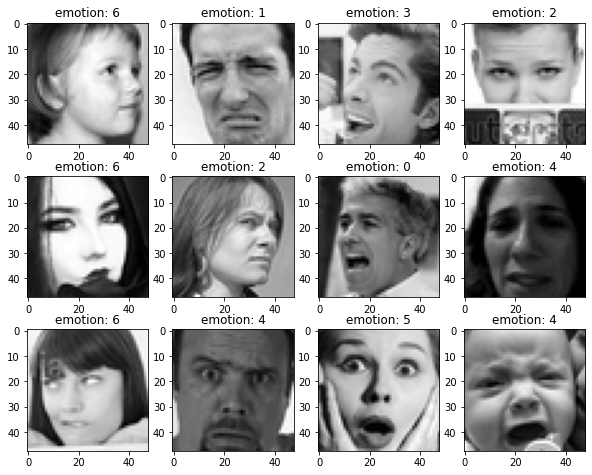

In [25]:
offset = 415
fig = plt.figure(figsize=(10, 8))
for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    ax.title.set_text('emotion: {}'.format(df['emotion'][i+offset]))
    plt.imshow(df['image'][i+offset], cmap='gray')
plt.show()

### Split Train & Test

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df['image'].values, df['emotion'].values, test_size=0.2)

### CUDA for PyTorch

In [28]:
import torch
import torchvision

In [29]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### Dataset Class

In [30]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image

In [31]:
class MyDataset(Dataset):
    
    def __init__(self, image, label, transform=None):
        self.image = image
        self.label = label
        self.transform = transform
        self.n_samples = len(self.image)
        
    def __getitem__(self, index):
        x = self.image[index]
        y = self.label[index]
        
        if self.transform:
            x = Image.fromarray(np.float32(self.image[index]))
            x = self.transform(x)  
            
        return x, y
        
    def __len__(self):
        return self.n_samples

In [35]:
mean = np.array([0.485])
std = np.array([0.229])

compsed_tr = Compose([ToTensor(), Normalize(mean, std)])

train_data = MyDataset(X_train, y_train, transform=compsed_tr)
test_data = MyDataset(X_test, y_test, transform=compsed_tr)

### Data Loader

In [36]:
batch_size = 10

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

train_data_loader = DataLoader(train_data, **params)
test_data_loader = DataLoader(test_data, **params)

In [37]:
import torch.nn as nn
import torch.nn.functional as F

from torch import optim

### Convolutional Neural Network

In [38]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # input_channel  -> gray = 1
        # output_channel -> 6
        # kernel         -> 3*3 
        self.conv1 = nn.Conv2d(1, 6, 3)
        
        # input_channel  -> 6
        # output_channel -> 6
        # kernel         -> 3*3 
        self.conv2 = nn.Conv2d(6, 6, 3)
        
        # kernel -> 3*3
        # stride -> 2
        self.pool = nn.MaxPool2d(3, 2)
        
        # input_channel  -> 6
        # output_channel -> 12
        # kernel         -> 3*3 
        self.conv3 = nn.Conv2d(6, 12, 3)
        
        # input_channel  -> 12
        # output_channel -> 12
        # kernel         -> 3*3 
        self.conv4 = nn.Conv2d(12, 12, 3)
        
        self.fc1 = nn.Linear(12*8*8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, n_classes)

    def forward(self, x):
                                              # ->  input     -> 1     , 48*48
        x = F.leaky_relu(self.conv1(x))       # ->  conv1     -> 6     , 46*46 
        x = F.leaky_relu(self.conv2(x))       # ->  conv2     -> 6     , 44*44
        x = self.pool(x)                      # ->  max-pool  -> 6     , 21*21
        
        x = F.leaky_relu(self.conv3(x))       # ->  conv3     -> 6×12  , 19*19 
        x = F.leaky_relu(self.conv4(x))       # ->  conv4     -> 6×12  , 17*17
        x = self.pool(x)                      # ->  max-pool  -> 6×12  , 8*8 
        
        x = x.view(-1, 12*8*8)                # ->  6×12(8*8)
        
        x = F.leaky_relu(self.fc1(x))         # ->  256
        x = F.leaky_relu(self.fc2(x))         # ->  64
        x = self.fc3(x)                       # -> 7
        return x

### Hyperparameters

In [39]:
n_classes = 7
n_epochs = 60
learning_rate = 0.001

### Model & Loss

In [40]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95) 

### Train

In [41]:
losses = []
learning_rates = []
for epoch in range(n_epochs):
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    lr=optimizer.param_groups[0]["lr"]
    learning_rates.append(lr)

    scheduler.step()
    
    losses.append(loss.item())

    print(f'epoch: {epoch+1}, lr: {lr}')

epoch: 1, lr: 0.001
epoch: 2, lr: 0.001
epoch: 3, lr: 0.001
epoch: 4, lr: 0.001
epoch: 5, lr: 0.001
epoch: 6, lr: 0.00095
epoch: 7, lr: 0.00095
epoch: 8, lr: 0.00095
epoch: 9, lr: 0.00095
epoch: 10, lr: 0.00095
epoch: 11, lr: 0.0009025
epoch: 12, lr: 0.0009025
epoch: 13, lr: 0.0009025
epoch: 14, lr: 0.0009025
epoch: 15, lr: 0.0009025
epoch: 16, lr: 0.000857375
epoch: 17, lr: 0.000857375
epoch: 18, lr: 0.000857375
epoch: 19, lr: 0.000857375
epoch: 20, lr: 0.000857375
epoch: 21, lr: 0.0008145062499999999
epoch: 22, lr: 0.0008145062499999999
epoch: 23, lr: 0.0008145062499999999
epoch: 24, lr: 0.0008145062499999999
epoch: 25, lr: 0.0008145062499999999
epoch: 26, lr: 0.0007737809374999998
epoch: 27, lr: 0.0007737809374999998
epoch: 28, lr: 0.0007737809374999998
epoch: 29, lr: 0.0007737809374999998
epoch: 30, lr: 0.0007737809374999998
epoch: 31, lr: 0.0007350918906249997
epoch: 32, lr: 0.0007350918906249997
epoch: 33, lr: 0.0007350918906249997
epoch: 34, lr: 0.0007350918906249997
epoch: 35, 

### Loss Plot

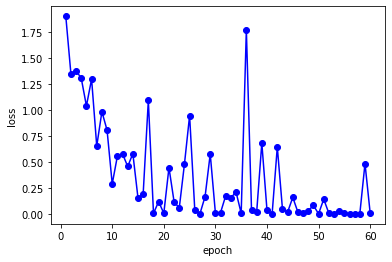

In [42]:
fig, ax = plt.subplots()

ax.plot(range(1, n_epochs+1, 1), losses, 'bo-')
ax.set(xlabel='epoch', ylabel='loss')
plt.show()

### Learning Rate Plot

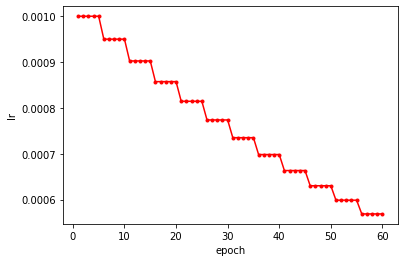

In [43]:
fig, ax = plt.subplots()

ax.plot(range(1, n_epochs+1, 1), learning_rates, 'r.-')
ax.set(xlabel='epoch', ylabel='lr')
plt.show()

### Test

In [44]:
torch.save(model.state_dict(), './cnn.pth')

In [45]:
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    
    n_class_correct = [0 for i in range(n_classes)]
    n_class_samples = [0 for i in range(n_classes)]
    
    for images, labels in test_data_loader: 
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # ignore values
        # convert output to 1-D
        _, predicted = torch.max(outputs, 1)
        
        batch_size = labels.size(0)
        n_samples += batch_size
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            prediction = predicted[i]
            
            if (label == prediction):
                n_class_correct[label] += 1
                
            n_class_samples[label] += 1

    for i in range(n_classes):
        acc = 100.0 * (n_class_correct[i] / n_class_samples[i])
        print(f'accuracy of emotion {classes[i]}: {acc:.2f}%\n')
        
    acc = 100.0 * (n_correct / n_samples)
    print(f'accuracy of the network: {acc:.2f}%')

accuracy of emotion 0: 36.64%

accuracy of emotion 1: 39.39%

accuracy of emotion 2: 31.87%

accuracy of emotion 3: 71.25%

accuracy of emotion 4: 42.96%

accuracy of emotion 5: 60.67%

accuracy of emotion 6: 46.76%

accuracy of the network: 50.02%
